In [1]:
import numpy as np
import matplotlib.pyplot as plt
import functools
import operator
import math

gdk:  1000 (2, 2) 2 2


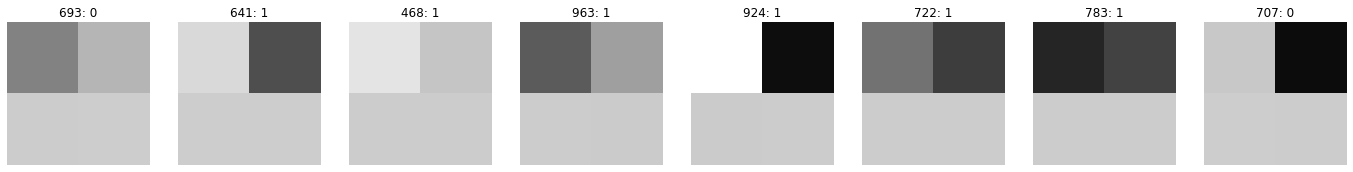

In [2]:
def show(data, labels=None, s=8):
    n, c, j = data.shape[0], data.shape[-1], 1
    labels = [None] * data.shape[0] if labels is None else labels
    plt.figure(figsize=(3 * (n if s == n else s), 3))
    for i in (range(n) if s == n else np.random.randint(0, n, s)):
        plt.subplot(1, s, j)
        plt.imshow(data[i], cmap="Greys", vmin=0, vmax=1)
        plt.title(str(i) + ": " + str(labels[i]))
        plt.axis("off")
        j += 1
    plt.show()

def gdk(n=1000, d=(2, 2), k=2, c=2, **kwargs):
    pd = functools.reduce(operator.mul, d, 1)
    assert(k <= pd)
    data = np.ones((n, *d))

    mask = np.arange(0, pd).reshape(d) < k
    common = np.ones((n, *d)) * 0.3
    random = np.random.random((n, *d))
    data = np.where(mask, random, common + 0.01 * random)
    labels = np.array([
        int((math.sin(d.flatten()[0] * 10) + 1) / 2 * c)
        for d in data])

    print("gdk: ", n, d, k, c)
    show(data, labels, **kwargs)
    return data, labels

gdk();

gdk:  8192 (2, 2) 2 2


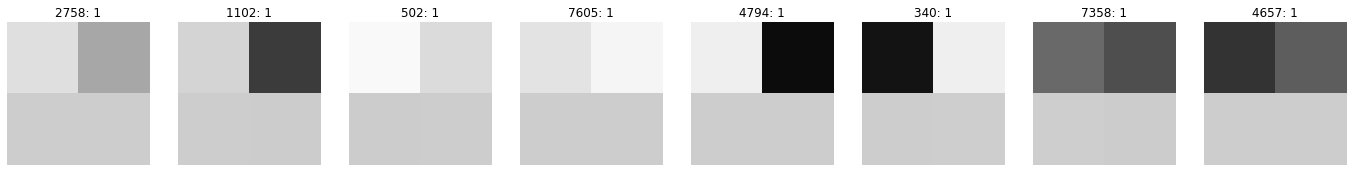

gdk:  1024 (2, 2) 2 2


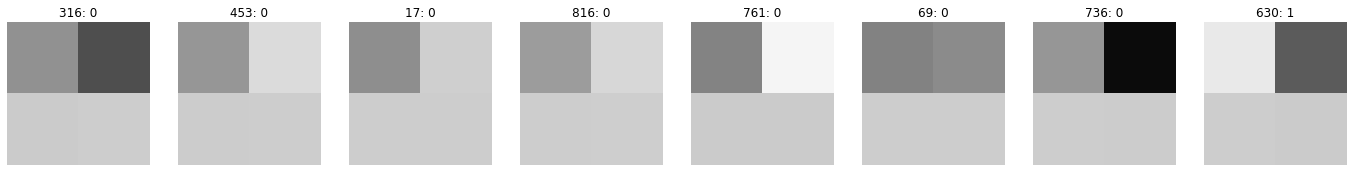

epoch 1 nerr 0.3642578125 loss 321.1275816955949
epoch 2 nerr 0.3642578125 loss 306.04473850407555
epoch 3 nerr 0.3642578125 loss 276.68563711214085
epoch 4 nerr 0.1279296875 loss 241.1244581800877
epoch 5 nerr 0.080078125 loss 207.51004085042723
epoch 6 nerr 0.087890625 loss 187.1457707365741
epoch 7 nerr 0.08203125 loss 175.2915655910553
epoch 8 nerr 0.0791015625 loss 165.94996643282116
epoch 9 nerr 0.064453125 loss 157.41425982109675
epoch 10 nerr 0.0537109375 loss 148.92738319640281
nerrtrain 0.073974609375
done


In [6]:
import jax
from jax.experimental import stax, optimizers
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
key = jax.random.PRNGKey(0)

ns, d, k, c, batch = (8192, 1024), (2, 2), 2, 2, 512
init_fun, model = jax.experimental.stax.serial(
    jax.experimental.stax.Flatten,
    jax.experimental.stax.Dense(16),
    jax.experimental.stax.Relu,
    jax.experimental.stax.Dense(16),
    jax.experimental.stax.Relu,
    jax.experimental.stax.Dense(c),
    jax.experimental.stax.LogSoftmax)
_, params = init_fun(key, (batch, *d))
opt_init, opt_update, get_params = \
    jax.experimental.optimizers.adam(0.005)
opt_state = opt_init(params)

def meval(model, params, xs, ys):
    correct = 0
    for step in range(len(xs) // batch):
        x, y = xs[step * batch:(step + 1) * batch], \
            ys[step * batch:(step + 1) * batch]
        pred = np.argmax(model(params, x), axis=1)
        correct += np.sum(pred == y)
    return correct / len(xs)

trainx, trainy, testx, testy = \
    *gdk(ns[0], d, k, c), *gdk(ns[1], d, k, c)
for epoch in range(30):
    for step in range(ns[0] // batch):
        x, y = trainx[step * batch:(step + 1) * batch], \
            trainy[step * batch:(step + 1) * batch]
        loss, grads = jax.value_and_grad(
            lambda params, xs, ys: -np.sum(model(params, xs) *
            np.array([[1 if i == label else 0
                for i in range(c)]
                for label in ys])) # adaptor for softmax out
        )(params, x, y)
        opt_state = opt_update(0, grads, opt_state)
        params = get_params(opt_state)
    print("epoch", epoch + 1, "nerr", 1 - meval(model, params, testx, testy), "loss", loss)
print("nerrtrain", 1 - meval(model, params, trainx, trainy))
print("done")

In [23]:
import adversarial_ntks
from adversarial_ntks import attacks

def grad_f(X):
    grads = []
    for a in range(batch):
        def fun(XX):
            preds = model(params, XX.reshape((len(XX), *d)))
            predclass = jnp.argmax(preds[a])
            return preds[a][predclass]
        fungrad = jax.grad(fun)
        grads.append(fungrad(X))
    grads = jnp.sum(jnp.array(grads), axis=0)
    return grads

pertxs = []
for step in range(len(testx) // batch):
    x, y = testx[step * batch:(step + 1) * batch].reshape((batch, -1)), \
        testy[step * batch:(step + 1) * batch]
    pertx = adversarial_ntks.attacks.pgd(x, y,
        grad_f, 0.02, 2, 10, 0.003, 2, True).reshape((batch, *d))
    pred = np.argmax(model(params, x), axis=1)
    print(np.sum(pred == y))
    pred = np.argmax(model(params, pertx), axis=1)
    print(np.sum(pred == y))
    pertxs.append(pertx)

485
461
484
474


aerr 0.0869140625


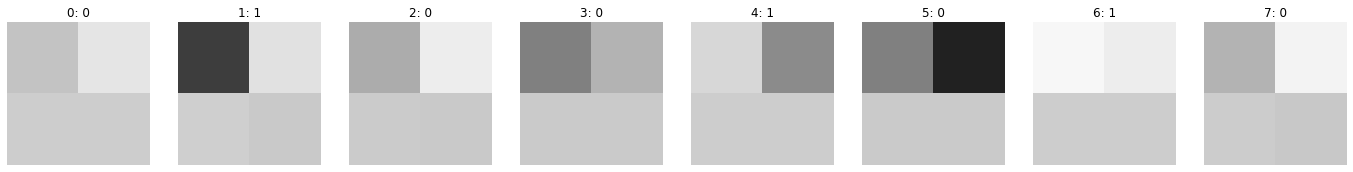

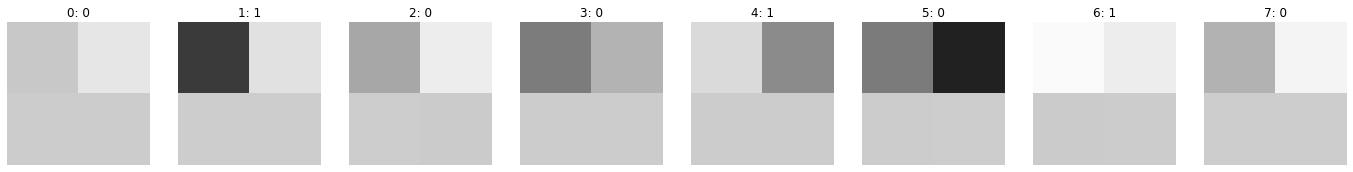

In [30]:
pertxs = np.array(pertxs).reshape((ns[1], *d))
print("aerr", 1 - meval(model, params, pertxs, testy))
show(pertxs[:8], testy, 8)
show(testx[:8], testy, 8)